In [83]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
def crop_brain_contour(image, plot=False):
    #convert to grayscale & blur
    gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray=cv2.GaussianBlur(gray,(5,5),0)

    #threshold valur setting to deal with noise
    thresh=cv2.threshold(gray,45,255,cv2.THRESH_BINARY)[1]
    thresh=cv2.erode(thresh,None,iterations=2)
    thresh=cv2.dilate(thresh,None,iterations=2)

    #find contours and its extreme points
    cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts=imutils.grab_contours(cnts)
    c=max(cnts,key=cv2.contourArea)

    #find the extreme points
    '''For example, Line 24 finds the smallest x-coordinate (i.e., the “west” value) in the entire contour array c by calling argmin() on the x-value and grabbing the entire (x, y)-coordinate associated with the index returned by argmin(). Similarly, Line 25 finds the largest x-coordinate (i.e., the “east” value) in the contour array using the argmax() function.
    Lines 26 and 27 perform the same operation, only for the y-coordinate, giving us the “north” and “south” coordinates, respectively.'''
    extLeft=tuple(c[c[:,:,0].argmin()][0])
    extRight=tuple(c[c[:,:,0].argmax()][0])
    extTop=tuple(c[c[:,:,1].argmin()][0])
    extBot=tuple(c[c[:,:,1].argmax()][0])

    new_image=image[extTop[1]:extBot[1],extLeft[0]:extRight[0]]
    
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

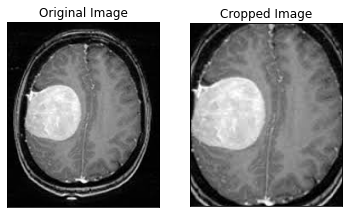

array([[[6, 6, 6],
        [6, 6, 6],
        [5, 5, 5],
        ...,
        [9, 9, 9],
        [9, 9, 9],
        [8, 8, 8]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [8, 8, 8],
        [8, 8, 8],
        [8, 8, 8]],

       [[5, 5, 5],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [8, 8, 8],
        [7, 7, 7],
        [7, 7, 7]],

       ...,

       [[6, 6, 6],
        [6, 6, 6],
        [7, 7, 7],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       [[5, 5, 5],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]],

       [[5, 5, 5],
        [5, 5, 5],
        [6, 6, 6],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]]], dtype=uint8)

In [3]:
#testing
img=cv2.imread('yes/Y1.jpg')
crop_brain_contour(img,True)

Read the image.
Crop the part of the image representing only the brain.
Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
Apply normalization because we want pixel values to be scaled to the range 0-1.
Append the image to X and its label to y.

In [4]:
def load_data(dir_list,image_size):
    x=[]
    y=[]
    width,height=image_size
    for directory in dir_list:
        for filename in listdir(directory):
            #read
            image=cv2.imread(directory+'\\'+filename)
            #crop
            crop_brain_contour(image,False)
            #resize
            image=cv2.resize(image, dsize=(width, height),interpolation=cv2.INTER_CUBIC)
            #normalise
            image=image/255
            #append
            x.append(image)
            if directory[-3:]=='yes':
                y.append([1])
            else:
                y.append([0])
    x=np.array(x)
    y=np.array(y)
    x,y=shuffle(x,y)
    print(f'Number of examples is: {len(x)}')
    print(f'X shape is: {x.shape}')
    print(f'y shape is: {y.shape}')
    
    return x, y

In [5]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

width,height = (240, 240)

x, y = load_data([augmented_yes, augmented_no],(width, height))

Number of examples is: 3273
X shape is: (3273, 240, 240, 3)
y shape is: (3273, 1)


In [6]:
def plot_sample_images(x, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = x[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

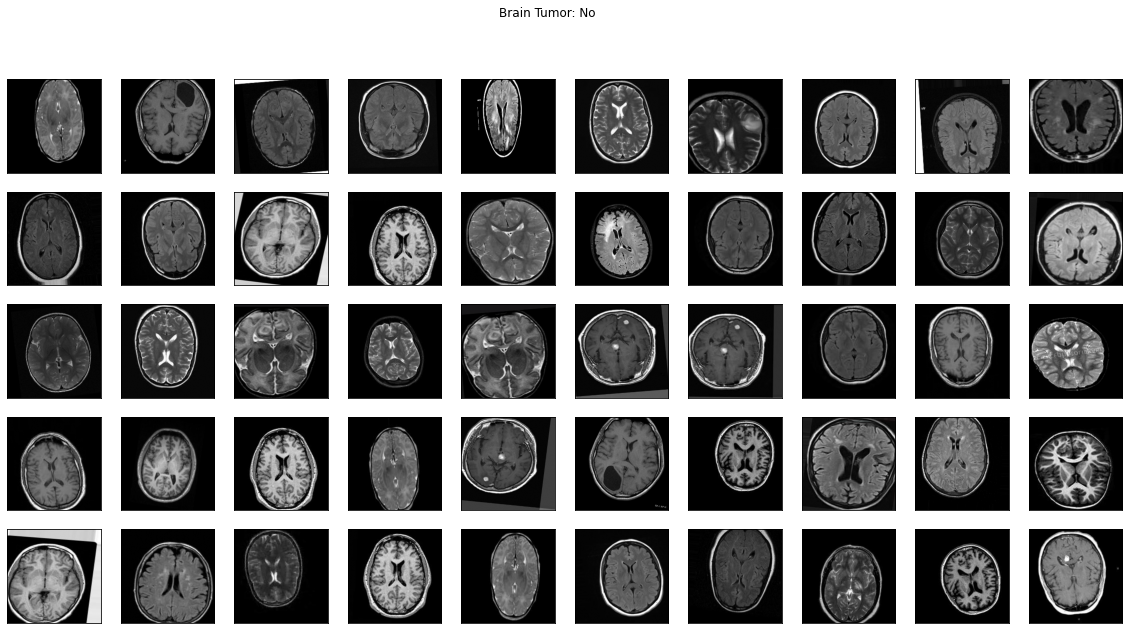

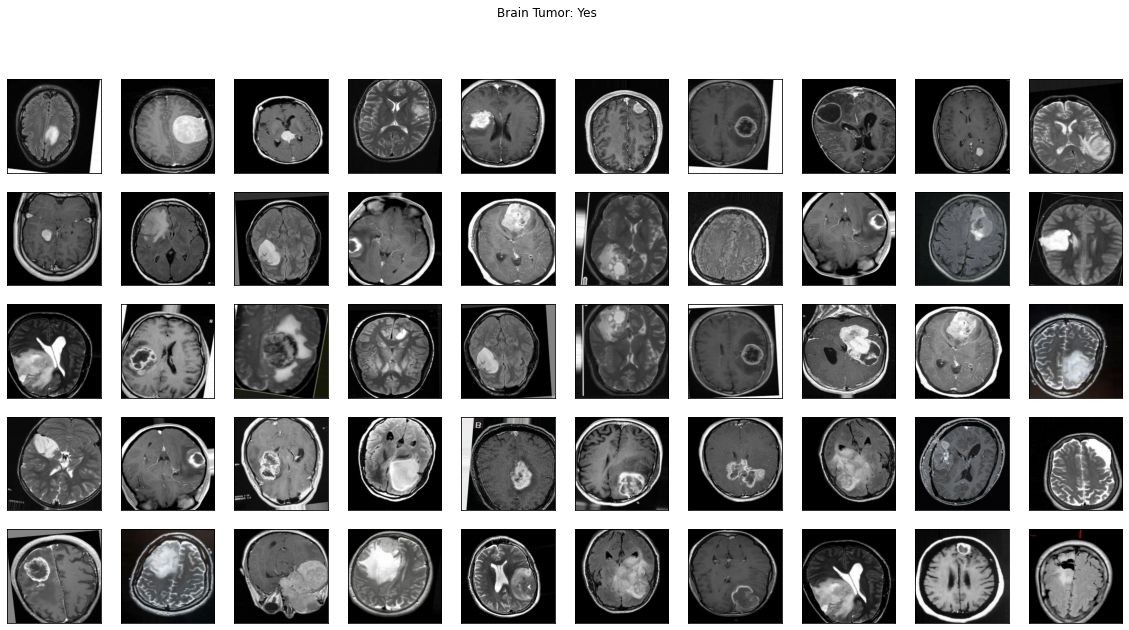

In [7]:
plot_sample_images(x,y)

## Splitting, training, testing

Splitting

In [8]:
def split(x,y,test_size):
    x_train,x_test_val,y_train,y_test_val=train_test_split(x,y,test_size=test_size)
    x_test,x_val,y_test,y_val=train_test_split(x_test_val,y_test_val,test_size=0.6)

    return x_train,y_train,x_test,y_test,x_val,y_val

In [9]:
x_train,y_train,x_test,y_test,x_val,y_val=split(x,y,.2)

In [10]:
print ("number of training samples = " + str(x_train.shape[0]))
print ("number of development samples = " + str(x_val.shape[0]))
print ("number of test samples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(x_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training samples = 2618
number of development samples = 393
number of test samples = 262
X_train shape: (2618, 240, 240, 3)
Y_train shape: (2618, 1)
X_val (dev) shape: (393, 240, 240, 3)
Y_val (dev) shape: (393, 1)
X_test shape: (262, 240, 240, 3)
Y_test shape: (262, 1)


In [11]:
#time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / 3600)
    m = int((sec_elapsed % 3600) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [87]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = metrics.f1_score(y_true, y_pred)
    
    return f"f1score: {score}"

Building the model

In [13]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 10))(X_input) # shape=(?, 244, 260, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 254, 64)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 63, 64) 
    
    #conv,BN,ReLU
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X) # shape=(?, 53, 57, 32)
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 13, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 5824)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [14]:
IMG_SHAPE = (width, height, 3)

In [15]:
model = build_model(IMG_SHAPE)

In [16]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 260, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 254, 64)      9472      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 254, 64)      256       
                                                                 
 activation (Activation)     (None, 238, 254, 64)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 63, 64)        0         
                                               

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [19]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [20]:
x_train.shape

(2618, 240, 240, 3)

In [21]:
start_time = time.time()

model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
82/82 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.6841

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.56.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.56.model\assets


82/82 [==============================] - 347s 4s/step - loss: 0.6299 - accuracy: 0.6841 - val_loss: 0.6975 - val_accuracy: 0.5649
Epoch 2/10
82/82 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.7788

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


82/82 [==============================] - 365s 4s/step - loss: 0.4707 - accuracy: 0.7788 - val_loss: 0.6031 - val_accuracy: 0.6310
Epoch 3/10
82/82 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8216

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.58.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.58.model\assets


82/82 [==============================] - 376s 5s/step - loss: 0.4050 - accuracy: 0.8216 - val_loss: 0.8519 - val_accuracy: 0.5751
Epoch 4/10
82/82 [==============================] - ETA: 0s - loss: 0.3488 - accuracy: 0.8461

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.60.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.60.model\assets


82/82 [==============================] - 388s 5s/step - loss: 0.3488 - accuracy: 0.8461 - val_loss: 0.9118 - val_accuracy: 0.6005
Epoch 5/10
82/82 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.8449

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.79.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.79.model\assets


82/82 [==============================] - 396s 5s/step - loss: 0.3328 - accuracy: 0.8449 - val_loss: 0.4387 - val_accuracy: 0.7939
Epoch 6/10
82/82 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.8778

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.77.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.77.model\assets


82/82 [==============================] - 422s 5s/step - loss: 0.2890 - accuracy: 0.8778 - val_loss: 0.5526 - val_accuracy: 0.7684
Epoch 7/10
82/82 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9102

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.84.model\assets


82/82 [==============================] - 380s 5s/step - loss: 0.2274 - accuracy: 0.9102 - val_loss: 0.3915 - val_accuracy: 0.8372
Epoch 8/10
82/82 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9095

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.84.model\assets


82/82 [==============================] - 382s 5s/step - loss: 0.2184 - accuracy: 0.9095 - val_loss: 0.4267 - val_accuracy: 0.8397
Epoch 9/10
82/82 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9343

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.86.model\assets


82/82 [==============================] - 362s 4s/step - loss: 0.1768 - accuracy: 0.9343 - val_loss: 0.3358 - val_accuracy: 0.8626
Epoch 10/10
82/82 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9534

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.83.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.83.model\assets


82/82 [==============================] - 322s 4s/step - loss: 0.1399 - accuracy: 0.9534 - val_loss: 0.4852 - val_accuracy: 0.8346
Elapsed time: 1:2:41.6


In [22]:
start_time = time.time()
model.fit(x=x_train, y=y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
82/82 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.9492

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


82/82 [==============================] - 330s 4s/step - loss: 0.1432 - accuracy: 0.9492 - val_loss: 0.3761 - val_accuracy: 0.8830
Epoch 2/5
82/82 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9595

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.79.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.79.model\assets


82/82 [==============================] - 342s 4s/step - loss: 0.1175 - accuracy: 0.9595 - val_loss: 0.8004 - val_accuracy: 0.7913
Epoch 3/5
82/82 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9717

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


82/82 [==============================] - 331s 4s/step - loss: 0.0953 - accuracy: 0.9717 - val_loss: 0.2840 - val_accuracy: 0.8931
Epoch 4/5
82/82 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9446

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.86.model\assets


82/82 [==============================] - 333s 4s/step - loss: 0.1350 - accuracy: 0.9446 - val_loss: 0.3490 - val_accuracy: 0.8601
Epoch 5/5
82/82 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9756

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.81.model\assets


82/82 [==============================] - 341s 4s/step - loss: 0.0829 - accuracy: 0.9756 - val_loss: 0.4999 - val_accuracy: 0.8092
Elapsed time: 0:28:14.7


In [23]:
start_time = time.time()
model.fit(x=x_train, y=y_train, batch_size=32, epochs=3, validation_data=(x_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
82/82 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9912

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.73.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.73.model\assets


82/82 [==============================] - 323s 4s/step - loss: 0.0528 - accuracy: 0.9912 - val_loss: 0.8298 - val_accuracy: 0.7252
Epoch 2/3
82/82 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9943

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets


82/82 [==============================] - 341s 4s/step - loss: 0.0416 - accuracy: 0.9943 - val_loss: 0.3548 - val_accuracy: 0.8702
Epoch 3/3
82/82 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9813

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.71.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.71.model\assets


82/82 [==============================] - 336s 4s/step - loss: 0.0559 - accuracy: 0.9813 - val_loss: 0.9546 - val_accuracy: 0.7125
Elapsed time: 0:16:56.7


In [24]:
start_time = time.time()
model.fit(x=x_train, y=y_train, batch_size=32, epochs=3, validation_data=(x_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
82/82 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9889

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.80.model\assets


82/82 [==============================] - 324s 4s/step - loss: 0.0449 - accuracy: 0.9889 - val_loss: 0.6274 - val_accuracy: 0.7964
Epoch 2/3
82/82 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9989

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.80.model\assets


82/82 [==============================] - 349s 4s/step - loss: 0.0234 - accuracy: 0.9989 - val_loss: 0.6135 - val_accuracy: 0.8041
Epoch 3/3
82/82 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9989

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.92.model\assets


82/82 [==============================] - 339s 4s/step - loss: 0.0176 - accuracy: 0.9989 - val_loss: 0.2792 - val_accuracy: 0.9211
Elapsed time: 0:17:7.7


In [25]:
start_time = time.time()
model.fit(x=x_train, y=y_train, batch_size=32, epochs=3, validation_data=(x_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
82/82 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 1.0000

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.92.model\assets


82/82 [==============================] - 330s 4s/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.2844 - val_accuracy: 0.9211
Epoch 2/3
82/82 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 1.0000

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.91.model\assets


82/82 [==============================] - 346s 4s/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.3050 - val_accuracy: 0.9109
Epoch 3/3
82/82 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 1.0000

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.91.model\assets


82/82 [==============================] - 329s 4s/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2889 - val_accuracy: 0.9135
Elapsed time: 0:17:1.5


In [26]:
history=model.history.history

In [27]:
for keys in history.keys():
    print(keys)

loss
accuracy
val_loss
val_accuracy


## Plot metrics

In [30]:
def plot_metrics(history):
    train_loss=history['loss']
    train_acc=history['accuracy']
    val_loss=history['val_loss']
    val_acc=history['val_accuracy']

    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_acc,label='Training Accuracy')
    plt.plot(val_acc,label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

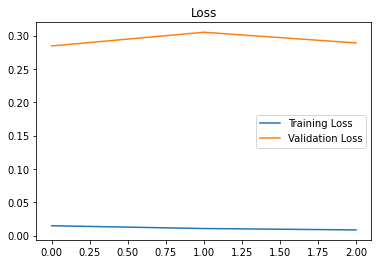

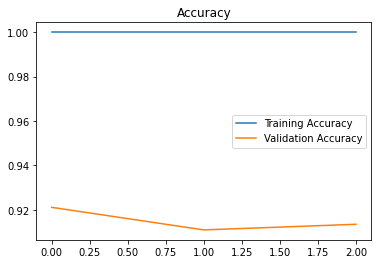

In [31]:
plot_metrics(history)

In [43]:
final_model=load_model(filepath='models\cnn-parameters-improvement-01-0.92.model')

In [33]:
model.metrics_names

['loss', 'accuracy']

In [45]:
loss,acc=model.evaluate(x=x_test,y=y_test)

9/9 [==============================] - 5s 548ms/step - loss: 0.3547 - accuracy: 0.8779


In [46]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.3547142744064331
Test Accuracy = 0.8778625726699829


In [85]:
y_test_prob = final_model.predict(x_test)

9/9 [==============================] - 8s 863ms/step


In [88]:
compute_f1_score(y_test,y_test_prob)

'f1score: 0.8937728937728937'

In [89]:
y_val_prob = final_model.predict(x_val)

13/13 [==============================] - 13s 965ms/step


In [92]:
final_model.evaluate(x_val,y_val)

13/13 [==============================] - 11s 812ms/step - loss: 0.2844 - accuracy: 0.9211


[0.2843731939792633, 0.9211195707321167]

In [91]:
f1val= compute_f1_score(y_val,y_val_prob)
f1val

'f1score: 0.929384965831435'

# Conclusion
We can successfully predict the presence of a brain tumour through analysing MRI scans of the same with 88% accuracy.

## We have finally achieved the following:
### Accuracy
Validation Set: 92%
Test Set: 88%
### F1 Score
Validation Set: 0.93
Test Set: 0.89